# Parse data from Woods & Poole County Forecast Files

In [1]:
import warnings
import pandas as pd
import glob
import os

pd.options.display.float_format = '{:,.0f}'.format
warnings.filterwarnings('ignore')

In [2]:
bayareafips_full = {'06001': 'Alameda',
                    '06013': 'Contra Costa',
                    '06041': 'Marin',
                    '06055': 'Napa',
                    '06075': 'San Francisco',
                    '06081': 'San Mateo',
                    '06085': 'Santa Clara',
                    '06097': 'Sonoma',
                    '06095': 'Solano'}

In [3]:
cog_regions = {'06001': 'ABAG/MTC',
               '06013': 'ABAG/MTC',
               '06041': 'ABAG/MTC',
               # '06053': 'AMBAG',
               '06055': 'ABAG/MTC',
               # '06069': 'AMBAG',
               '06075': 'ABAG/MTC',
               '06073': 'SANDAG',
               '06081': 'ABAG/MTC',
               '06085': 'ABAG/MTC',
               # '06087': 'AMBAG',
               '06095': 'ABAG/MTC',
               '06097': 'ABAG/MTC',
               # '06077': 'SJCOG',
               # '06099': 'STANCOG',
               # '06047': 'MCAG',
               '06025': 'SCAG',  # imperial
               '06037': 'SCAG',   # LA
               '06071': 'SCAG',  # san bernadino
               '06059': 'SCAG',  # orange
               '06065': 'SCAG',  # riverside
               '06111': 'SCAG',  # ventura
               '06067': 'SACOG',  # 'yolo'
               '06101': 'SACOG',  # 'sutter'
               '06113': 'SACOG',  # 'yolo'
               '06115': 'SACOG'
               }

cog_regions

{'06001': 'ABAG/MTC',
 '06013': 'ABAG/MTC',
 '06041': 'ABAG/MTC',
 '06055': 'ABAG/MTC',
 '06075': 'ABAG/MTC',
 '06073': 'SANDAG',
 '06081': 'ABAG/MTC',
 '06085': 'ABAG/MTC',
 '06095': 'ABAG/MTC',
 '06097': 'ABAG/MTC',
 '06025': 'SCAG',
 '06037': 'SCAG',
 '06071': 'SCAG',
 '06059': 'SCAG',
 '06065': 'SCAG',
 '06111': 'SCAG',
 '06067': 'SACOG',
 '06101': 'SACOG',
 '06113': 'SACOG',
 '06115': 'SACOG'}

# Labor Force, Employment file

In [4]:
# labor force, employment detail data file

data_emp_fieldmap = pd.read_fwf('/Users/aolsen/Box/DataViz Projects/Data Services/Woods & Poole Forecasting/data/WP_Download_2023/SP_2023_CA/WPCOMP/CACOMP.CSV',
                                skiprows=121, skipfooter=24, widths=[2, 15, 92, 1], names=['no', 'variable', 'desc', 'no1'])

data_emp_fieldmap.variable = data_emp_fieldmap.variable.str.strip()
data_emp_fieldmap.desc = data_emp_fieldmap.desc.str.strip()
data_emp_fieldmap = data_emp_fieldmap.set_index('variable').desc

In [5]:
# read data file itself
data_emp = pd.read_csv('/Users/aolsen/Box/DataViz Projects/Data Services/Woods & Poole Forecasting/data/WP_Download_2023/SP_2023_CA/WPCOMP/CACOMP.CSV',
                       skiprows=3, skipfooter=75, dtype={'COUNTY': str})

In [6]:
# list of file row identifiers - we don't need most of these
IDENTIFIERS = ['COUNTY', 'TYPE', 'REGION',
               'EA', 'MSA', 'CSA', 'MDIV', 'MICRO', 'NAME']

In [7]:
# subset to bay area counties
data_emp_bayarea = data_emp[data_emp.COUNTY.isin(bayareafips_full)]

# drop not relevant identifiers - set the remaining variable to be the index variable. Rest of columns are years
data_emp_bayarea = data_emp_bayarea.drop(
    IDENTIFIERS[:-1], axis=1).set_index('NAME')

# turn to long format
data_emp_bayarea_l = data_emp_bayarea.stack().reset_index(name='value')


# some variables contain both a concept and a detail ('TOTL, 1-49 EST', 'TOTL, ALL EST')
# strip out just the year. The dictionary is just focused on the first component, which we call "stub"
data_emp_bayarea_l['variable_no_year'] = data_emp_bayarea_l.level_1.str.replace(
    ', \d{4}', '')


data_emp_bayarea_l['variable_stub'] = data_emp_bayarea_l['variable_no_year'].str.split(
    ',').apply(lambda x: x[0])

# column headers encode both concept and years. Extract.
data_emp_bayarea_l['variable'] = data_emp_bayarea_l.level_1.str.slice(
    0, -6).str.strip()
data_emp_bayarea_l['year'] = data_emp_bayarea_l.level_1.str.slice(
    -4).astype(int)

# add descriptive field name from field map
data_emp_bayarea_l['variable_name'] = data_emp_bayarea_l.variable_stub.map(
    data_emp_fieldmap)


# drop unused var
data_emp_bayarea_l = data_emp_bayarea_l.drop(['level_1'], axis=1)

data_emp_bayarea_l.sample(3)

,NAME,value,variable_no_year,variable_stub,variable,year,variable_name
1597,"SONOMA, CA",257,"ENMT, 1-49 EST",ENMT,"ENMT, 1-49 EST",2019,"Arts, Entertainment, and Recreation Business E..."
507,"MARIN, CA",767,"OTHR, 1-49 EST",OTHR,"OTHR, 1-49 EST",2019,Other Services (except Public Administration) ...
621,"NAPA, CA",236,"ADMN, 1-49 EST",ADMN,"ADMN, 1-49 EST",2018,Administrative & Support and Waste Management ...


In [8]:
data_emp_bayarea_l[data_emp_bayarea_l.variable_stub == 'TOTL'].sample(3)

,NAME,value,variable_no_year,variable_stub,variable,year,variable_name
1174,"SANTA CLARA, CA","3,159","TOTL, 50+ EST",TOTL,"TOTL, 50+ EST",2018,Total Number of Business Establishments
852,"SAN FRANCISCO, CA","32,459","TOTL, 1-49 EST",TOTL,"TOTL, 1-49 EST",2019,Total Number of Business Establishments
1496,"SONOMA, CA","14,304","TOTL, ALL EST",TOTL,"TOTL, ALL EST",2018,Total Number of Business Establishments


# General Files

These are stored as a separate file for each variable (122 in total).

There is a mapping detailing what each file contains - we load the mapping and the data, and stitch together as appropriate.

In [9]:
VARIABLE_MAP_PATH = '/Users/aolsen/Box/DataViz Projects/Data Services/Woods & Poole Forecasting/data/WP_Download_2023/SP_2023_CA/CAFILENM.TXT'
VARIABLE_PATH = '/Users/aolsen/Box/DataViz Projects/Data Services/Woods & Poole Forecasting/data/WP_Download_2023/SP_2023_CA/WPVAR'
DATA_PATH = '/Users/aolsen/Box/DataViz Projects/Data Services/Woods & Poole Forecasting/data/WP_Download_2023/SP_2023_CA/WPVAR'

In [10]:
# load the file name to variable map into a series

variable_file_map = pd.read_fwf(
    VARIABLE_MAP_PATH, skiprows=10, skipfooter=119, widths=[13, 76])
variable_file_map = variable_file_map.set_index('FILE NAME').VARIABLE
variable_file_map

FILE NAME
CA001.CSV                                     TOTAL POPULATION
CA002.CSV                         POPULATION AGE UNDER 5 YEARS
CA003.CSV                          POPULATION AGE 5 to 9 YEARS
CA004.CSV                        POPULATION AGE 10 to 14 YEARS
CA005.CSV                        POPULATION AGE 15 to 19 YEARS
                                   ...                        
CA118.CSV    SPORTING GOODS, HOBBY, BOOK, and MUSIC STORES ...
CA119.CSV              GENERAL MERCHANDISE STORES RETAIL SALES
CA120.CSV                     MISCELLANEOUS STORE RETAIL SALES
CA121.CSV                      NONSTORE RETAILERS RETAIL SALES
CA122.CSV                     EATING and DRINKING PLACES SALES
Name: VARIABLE, Length: 122, dtype: object

In [11]:
for fname in glob.glob1(VARIABLE_PATH, '*CSV'):

    # construct the path
    full_fname = os.path.join(VARIABLE_PATH, fname)

    # read the datafile
    this_df = pd.read_csv(full_fname, skiprows=3,
                          skipfooter=87, dtype={'COUNTY': str})

In [12]:
def fetch_and_stitch_data(VARIABLE_PATH, variable_file_map, subset=False):
    """
    Fetches Woods and Poole County forecast data, stitches the data together from different files,
    and stores it in a long format dataframe.

    Args:
        VARIABLE_PATH (str): Path to the directory containing variable files.
        variable_file_map (dict): A dictionary mapping file names to variable names.
        bayareafips_full (list): List of county FIPS codes for the Bay Area.

    Returns:
        pandas.DataFrame: The stitched and processed data in a long format dataframe.
    """

    storage = {}

    # loop over list of all variable files in folder
    for fname in glob.glob1(VARIABLE_PATH, '*CSV'):

        # construct the path
        full_fname = os.path.join(VARIABLE_PATH, fname)

        # read the datafile - ensure COUNTY fips code doesn't lose leading 0
        this_df = pd.read_csv(full_fname, skiprows=3,
                              skipfooter=87, dtype={'COUNTY': str})

        # look up from the file name what variable it represents
        this_var = variable_file_map[fname]

        # store in a dict keyed on the variable name
        storage[this_var] = this_df

    # combine the individual variables
    wp_data = pd.concat(storage, names=['VARIABLE', 'ROWID']).reset_index()

    # assign COG region based on county
    wp_data['cog_region'] = wp_data.COUNTY.map(cog_regions)

    # drop non-cog counties
    wp_data = wp_data[wp_data.cog_region.notna()]

    # subset to bay area counties
    if subset:
        wp_data = wp_data[wp_data.COUNTY.isin(bayareafips_full)]

    wp_data = wp_data.drop(wp_data.columns[1:11], axis=1)
    wp_data_l = wp_data.set_index(
        ['VARIABLE', 'NAME', 'cog_region']).stack().reset_index(name='value')

    wp_data_l = wp_data_l.rename(
        columns={'VARIABLE': 'variable', 'NAME': 'county', 'level_3': 'year'})

    wp_data_l.year = wp_data_l.year.astype(int)

    return wp_data_l

wp_data_l = fetch_and_stitch_data(
    VARIABLE_PATH, variable_file_map, subset=False)
wp_data_l.sample(3)

,variable,county,cog_region,year,value
157188,CONTRIBUTIONS for GOVERNMENT SOCIAL INSURANCE,"SACRAMENTO, CA",SACOG,2021,"6,251"
76759,INFORMATION EMPLOYMENT,"SOLANO, CA",ABAG/MTC,2000,2
182765,"NUMBER of HOUSEHOLDS with MONEY INCOME $20,000...","ORANGE, CA",SCAG,2022,77


## Summaries

In [13]:
years_5 = range(2010, 2051, 5)

### Bay Area Total

In [14]:
# which vars to keep?
var_keep = ['TOTAL NUMBER of HOUSEHOLDS',
            'TOTAL POPULATION', 'TOTAL EMPLOYMENT']

In [15]:
bay_area_totals = wp_data_l[wp_data_l.variable.isin(var_keep)].groupby(
    ['variable', 'year']).value.sum().unstack(0).mul(1e3).astype(int)

### County Totals

In [16]:
county_totals = wp_data_l[wp_data_l.variable.isin(var_keep)].groupby(
    ['county', 'variable', 'year']).value.sum().unstack(0).mul(1e3).astype(int)

In [17]:
county_households = wp_data_l.query("variable=='TOTAL NUMBER of HOUSEHOLDS'").groupby([
    'county', 'year']).value.sum().unstack(0)

In [18]:
# Household growth, 2020 - 2050
#county_households.loc['2050'] - county_households.loc['2020']

### COG Totals

<AxesSubplot: xlabel='year'>

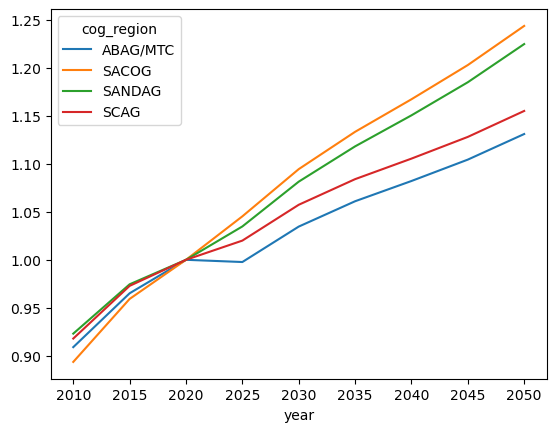

In [19]:
COG_households = wp_data_l.query("variable=='TOTAL NUMBER of HOUSEHOLDS'").groupby([
    'cog_region', 'year']).value.sum().unstack(0)
# county_households.plot()
COG_households = COG_households.mul(1000).astype(int)

(COG_households.loc[years_5]/COG_households.loc[2020]).plot()

<AxesSubplot: xlabel='cog_region'>

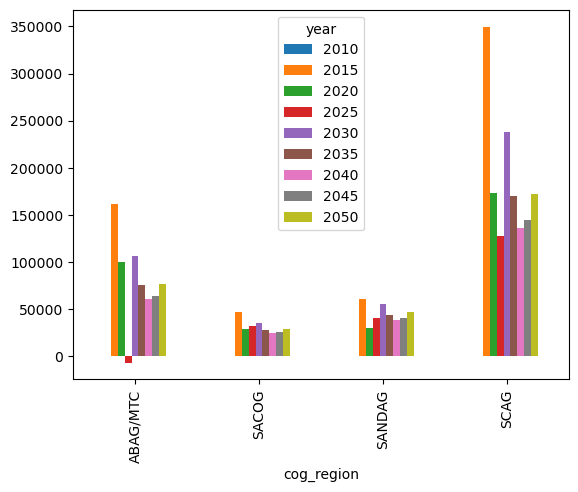

In [20]:
COG_households.loc[years_5].diff().T.plot(kind='bar')